Classifying facebook/bart-large-mnli:   0%|          | 0/99 [00:00<?, ?it/s]

Extracting activations facebook/bart-large-mnli:   0%|          | 0/99 [00:00<?, ?it/s]

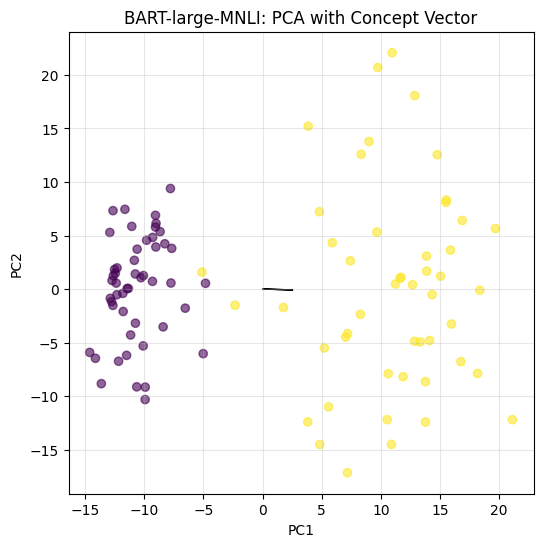

Classifying textattack/bert-base-uncased-MNLI:   0%|          | 0/99 [00:00<?, ?it/s]

Extracting activations textattack/bert-base-uncased-MNLI:   0%|          | 0/99 [00:00<?, ?it/s]

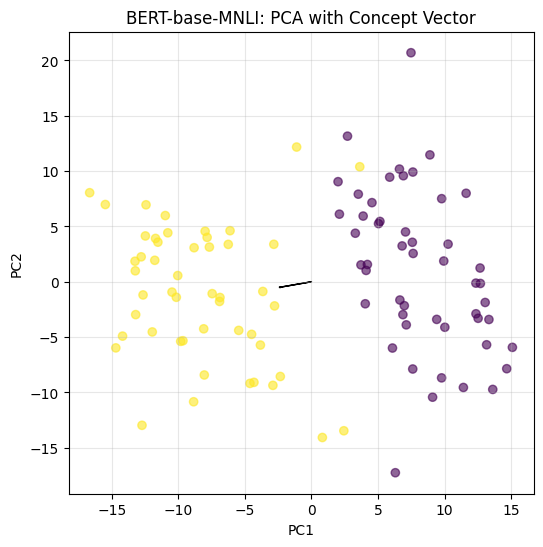

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/688 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Classifying roberta-large-mnli:   0%|          | 0/99 [00:00<?, ?it/s]

Extracting activations roberta-large-mnli:   0%|          | 0/99 [00:00<?, ?it/s]

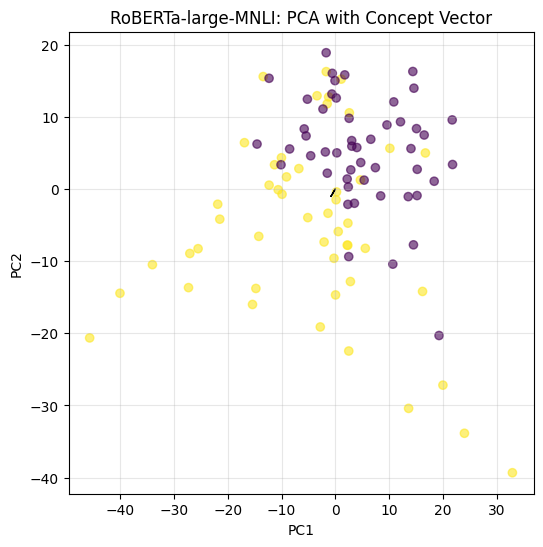

tokenizer_config.json:   0%|          | 0.00/395 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.65M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/18.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/870M [00:00<?, ?B/s]

Classifying MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli:   0%|          | 0/99 [00:00<?, ?it/s]

Extracting activations MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli:   0%|          | 0/99 [00:00<…

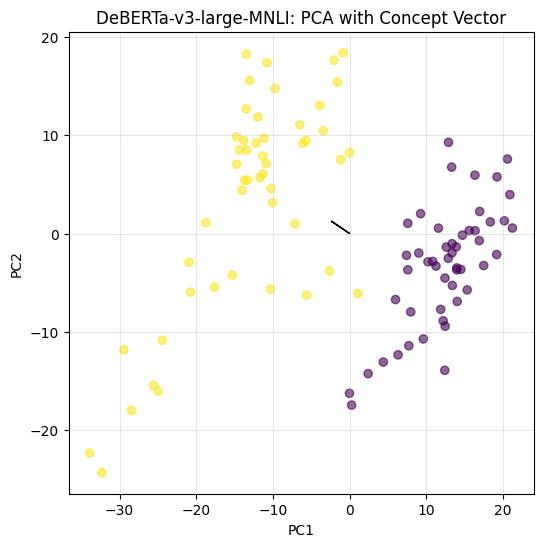

                      sep_acc mean_slang mean_nonslang   strength direction  \
BART-large-MNLI           1.0   9.551397     -9.360369  18.911766     SLANG   
BERT-base-MNLI            1.0   7.490679     -7.340866  14.831545     SLANG   
RoBERTa-large-MNLI        1.0   7.979444     -7.819855  15.799299     SLANG   
DeBERTa-v3-large-MNLI     1.0    11.7281    -11.493538  23.221637     SLANG   

                          t_stat p_val    effect  
BART-large-MNLI        46.809972   0.0  1.957249  
BERT-base-MNLI         45.888937   0.0  1.955569  
RoBERTa-large-MNLI      47.66768   0.0   1.95873  
DeBERTa-v3-large-MNLI  49.020277   0.0  1.960916  


In [2]:
# TCAV Analysis Notebook - Aligned with fire_slang_dataset.csv Structure
# =============================================================================
# CONFIGURATION
# =============================================================================
import argparse
import os
import logging
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from scipy import stats

# -----------------------
# Default Dataset Config
# -----------------------
DATA_CONFIG = {
    "file_path": "fire_slang_dataset.csv",   # default filename in working dir
    "delimiter": ",",
    "text_column": "sentence",               # column name for text
    "label_column": "slang",                 # column name for binary label (yes/no)
    "confidence_column": None,                 # not present in this dataset
    "invert_labels": False                     
}

# -----------------------
# Google Colab Upload
# -----------------------
try:
    from google.colab import files
    if not os.path.exists(DATA_CONFIG['file_path']):
        print("📁 Please upload your dataset CSV file:")
        uploaded = files.upload()
        DATA_CONFIG['file_path'] = next(iter(uploaded))
        print(f"✅ Using uploaded file: {DATA_CONFIG['file_path']}")
except ImportError:
    pass

# -----------------------
# Models to Evaluate
# -----------------------
MODEL_CONFIG = {
    "BART-large-MNLI": "facebook/bart-large-mnli",
    "BERT-base-MNLI": "textattack/bert-base-uncased-MNLI",
    "RoBERTa-large-MNLI": "roberta-large-mnli",
    "DeBERTa-v3-large-MNLI": "MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli"
}

# Analysis Parameters
MAX_LENGTH = 128
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s %(message)s')
logger = logging.getLogger(__name__)

# =============================================================================
# DATA LOADING
# =============================================================================
def load_data(config):
    """Load dataset with explicit column mapping and label conversion."""
    path = config["file_path"]
    if not os.path.exists(path):
        raise FileNotFoundError(f"Dataset '{path}' not found. Please upload or check the path.")
    df = pd.read_csv(path, sep=config.get("delimiter", ",") or ",")

    # Ensure required columns exist
    for col in [config["text_column"], config["label_column"]]:
        if col not in df.columns:
            raise KeyError(f"Column '{col}' not found in CSV. Available: {list(df.columns)}")

    # Extract sentences
    sentences = df[config["text_column"]].astype(str).tolist()

    # Convert 'slang' yes/no to 1/0 or numeric
    labels_raw = df[config["label_column"]]
    if labels_raw.dtype == object:
        labels = labels_raw.str.lower().map({'yes':1,'no':0}).astype(int).tolist()
    else:
        labels = pd.to_numeric(labels_raw, errors='raise').astype(int).tolist()

    #  invert labels
    if config.get("invert_labels"):
        labels = [1 - l for l in labels]
        logger.info("Labels inverted per configuration.")

    # No confidence column in this dataset
    confidence = [0] * len(sentences)

    logger.info(f"Loaded {len(sentences)} examples. Using label column '{config['label_column']}'.")
    return sentences, labels, confidence

# =============================================================================
# QUICK CLASSIFICATION
# =============================================================================
def quick_classify_model(model_id, sentences):
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForSequenceClassification.from_pretrained(model_id).to(DEVICE).eval()
    preds = []
    for sent in tqdm(sentences, desc=f"Classifying {model_id}", leave=False):
        hypotheses = ["This example is slang.", "This example is non-slang."]
        encoded = tokenizer([sent, sent], hypotheses,
                             return_tensors="pt", padding=True,
                             truncation=True, max_length=MAX_LENGTH).to(DEVICE)
        with torch.no_grad():
            logits = model(**encoded).logits[:,2]
            choice = torch.argmax(F.softmax(logits, dim=0)).item()
        preds.append(1 if choice==0 else 0)
    return preds

# =============================================================================
# ACTIVATION EXTRACTION
# =============================================================================
def extract_activations(model_id, sentences, layer_idx=-2):
    """Extract hidden layer activations for any transformer model."""
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModel.from_pretrained(model_id).to(DEVICE).eval()
    activations = []

    for sent in tqdm(sentences, desc=f"Extracting activations {model_id}", leave=False):
        inputs = tokenizer(sent,
                          return_tensors="pt",
                          truncation=True,
                          padding=True,
                          max_length=MAX_LENGTH).to(DEVICE)
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            # For encoder-decoder models, use encoder_hidden_states; otherwise hidden_states
            if hasattr(outputs, 'encoder_hidden_states') and outputs.encoder_hidden_states is not None:
                hs = outputs.encoder_hidden_states
            else:
                hs = outputs.hidden_states
            hidden_layer = hs[layer_idx]
            pooled = hidden_layer.mean(dim=1).squeeze().cpu().numpy()
        activations.append(pooled)
    return np.vstack(activations)

# =============================================================================
# TCAV ANALYZER
# =============================================================================
class TCAVAnalyzer:
    def __init__(self, activations, labels, preds, model_name):
        self.acts = activations
        self.labels = np.array(labels)
        self.preds = np.array(preds)
        self.name = model_name
        self.scaler = StandardScaler().fit(self.acts)
        self.acts_scaled = self.scaler.transform(self.acts)

    def find_concept_vector(self):
        clf = LogisticRegression(max_iter=1000).fit(self.acts_scaled, self.labels)
        vec = clf.coef_[0] / np.linalg.norm(clf.coef_[0])
        acc = accuracy_score(self.labels, clf.predict(self.acts_scaled))
        return vec, acc

    def compute_tcav(self, vec):
        return self.acts_scaled.dot(vec)

    def analyze_bias(self, scores):
        s_mask, n_mask = self.labels==1, self.labels==0
        ms, mn = scores[s_mask].mean(), scores[n_mask].mean()
        strength = abs(ms-mn)
        direction = 'SLANG' if ms>mn else 'NON-SLANG'
        t,p = stats.ttest_ind(scores[s_mask], scores[n_mask])
        return {'mean_slang':ms,'mean_nonslang':mn,
                'strength':strength,'direction':direction,
                't_stat':t,'p_val':p,
                'effect':strength/scores.std() if scores.std()!=0 else 0}

    def plot(self, vec, scores):
        """Plot PCA projection with concept vector."""
        pca = PCA(n_components=2)
        p2 = pca.fit_transform(self.acts_scaled)
        vec2d = pca.components_.dot(vec)

        plt.figure(figsize=(6,6))
        plt.scatter(p2[:,0], p2[:,1], c=self.labels, alpha=0.6)
        plt.arrow(0, 0, vec2d[0]*3, vec2d[1]*3,
                  head_width=0.1, head_length=0.1, fc='black', ec='black')
        plt.title(f"{self.name}: PCA with Concept Vector")
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.grid(True, alpha=0.3)
        plt.show()

# =============================================================================
# MAIN PIPELINE
# =============================================================================
def run_analysis(cfg, models):
    sentences, labels, _ = load_data(cfg)
    results = {}
    for name, mid in models.items():
        logger.info(f"==> {name}")
        preds = quick_classify_model(mid, sentences)
        acts = extract_activations(mid, sentences)
        analyzer = TCAVAnalyzer(acts, labels, preds, name)
        vec, sep_acc = analyzer.find_concept_vector()
        scores = analyzer.compute_tcav(vec)
        bias = analyzer.analyze_bias(scores)
        analyzer.plot(vec, scores)
        results[name] = {'sep_acc':sep_acc, **bias}
    return results

# =============================================================================
# EXECUTION
# =============================================================================
if __name__ == '__main__':
    args, _ = argparse.ArgumentParser().parse_known_args()
    tcav_res = run_analysis(DATA_CONFIG, MODEL_CONFIG)
    import pandas as __pd; print(__pd.DataFrame(tcav_res).T)
